In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

zip_id = '1upOcakmV4Ym2sv-5K3MY88rA_QNzTXJV'
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('model.zip')
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('model.zip', 'r')
zip_ref.extractall("breast_density_dataset")
zip_ref.close()

Uncompressing zip file


In [0]:
def read_image_and_breast_mask(h5_filename):
    # 'r' mode is very important ! 
    with h5py.File(h5_filename, "r") as h5_file:
        image = h5_file["image"][:]
        breast_mask = h5_file["mask"][:]

    return image, breast_mask

In [0]:
!mkdir train
!mkdir train/images
!mkdir train/masks

In [0]:
import pandas as pd
import numpy as np
import os
import h5py
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
import pandas as pd
valid = pd.read_csv("breast_density_dataset/train.csv",nrows=2000)
train = pd.read_csv("breast_density_dataset/train.csv", skiprows=2000)
train.columns = valid.columns

train.to_csv("train.csv",index=False)
valid.to_csv("valid.csv",index=False)

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
def batch_generator(Train_df,batch_size,steps):
 idx=1
 while True: 
  yield load_data(Train_df,idx-1,batch_size)## Yields data
  if idx<steps:
    idx+=1
  else:
    idx=1

In [0]:
TRAIN_DIR = "breast_density_dataset/train/"
TEST_DIR = "breast_density_dataset/test/"

def load_data(Train_df,idx,batch_size):
 df = pd.read_csv(Train_df, skiprows=idx*batch_size,nrows=batch_size)
 x = []
 y = []
 for  row  in df.values:
  image_uid=row[0]
  image_file = os.path.join(TRAIN_DIR, image_uid + ".h5")
  X, breast_mask = read_image_and_breast_mask(image_file)

  image = (X - X.min()) / (X.max() - X.min())
  image=resize(image, (128, 128, 1), mode='constant', preserve_range=True)

  breast_mask=resize(breast_mask, (128, 128, 1), mode='constant', preserve_range=True)

  x.append(np.uint8(image)) 
  y.append(breast_mask) 

 #df.iloc[:,1:]
# y = df.iloc[:,0] 
 return (np.array(x).reshape(-1,128,128,1), np.array(y).reshape(-1,128,128,1))

In [0]:
import numpy as np
batch_size=256
steps_per_epoch=np.ceil(7960/batch_size)
validation_steps=np.ceil(2000/batch_size)

my_training_batch_generator = batch_generator('train.csv', 256,steps_per_epoch)
my_validation_batch_generator = batch_generator('valid.csv', 256,validation_steps)

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img,input_latent, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    

    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    

    model = Model(inputs=[input_img], outputs=[outputs])

    return model

In [0]:
im_height=128
im_width=128
input_img = Input((im_height, im_width, 1), name='img')
input_latent = Input((512,), name='latent')
model = get_unet(input_img,input_latent, n_filters=64, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [14]:
results = model.fit_generator(my_training_batch_generator,epochs=100,steps_per_epoch=steps_per_epoch,verbose=1, validation_data=my_validation_batch_generator,validation_steps=validation_steps, callbacks=callbacks)



Epoch 1/100
32/32 [==============================] - 86s 3s/step - loss: 0.6268 - acc: 0.6237 - val_loss: 2.3983 - val_acc: 0.6147

Epoch 00001: val_loss improved from inf to 2.39834, saving model to model-tgs-salt.h5
Epoch 2/100
32/32 [==============================] - 63s 2s/step - loss: 0.5803 - acc: 0.6484 - val_loss: 1.7354 - val_acc: 0.6147

Epoch 00002: val_loss improved from 2.39834 to 1.73536, saving model to model-tgs-salt.h5
Epoch 3/100
32/32 [==============================] - 73s 2s/step - loss: 0.5742 - acc: 0.6519 - val_loss: 0.6815 - val_acc: 0.6405

Epoch 00003: val_loss improved from 1.73536 to 0.68149, saving model to model-tgs-salt.h5
Epoch 4/100
32/32 [==============================] - 73s 2s/step - loss: 0.5722 - acc: 0.6523 - val_loss: 0.6095 - val_acc: 0.6496

Epoch 00004: val_loss improved from 0.68149 to 0.60953, saving model to model-tgs-salt.h5
Epoch 5/100
32/32 [==============================] - 73s 2s/step - loss: 0.5717 - acc: 0.6525 - val_loss: 0.6833 -

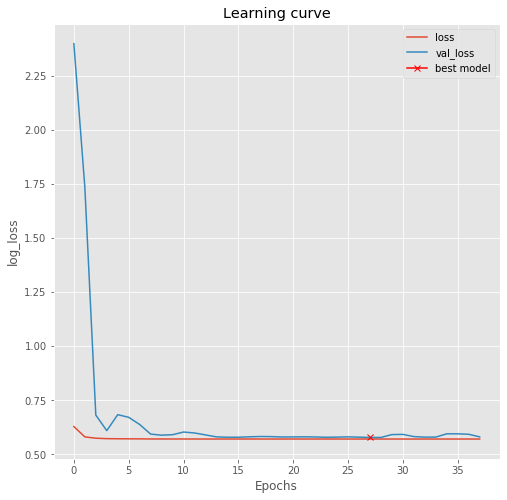

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
test = pd.read_csv("breast_density_dataset/test.csv")

In [0]:
image_uid=test.values[0,0]
image_file = os.path.join(TEST_DIR, image_uid + ".h5")
X, breast_mask = read_image_and_breast_mask(image_file)
image = (X - X.min()) / (X.max() - X.min())

pred= model.predict(resize(image, (128, 128, 1), mode='constant', preserve_range=True).reshape(1,128,128,1))
mask=np.array(np.round(pred > 0.5)).reshape((128, 128)).astype('uint8')

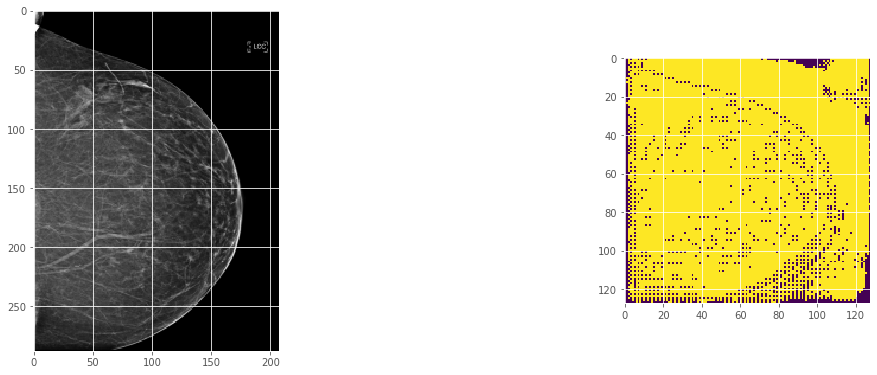

In [33]:
plt.figure(figsize=(15, 20))
plt.subplot(131)
plt.imshow(image, cmap='gray')



plt.subplot(133)
plt.imshow(mask)
plt.show()

In [0]:
from keras import backend as K
inp = model.input 
layer_output = model.get_layer('conv2d_10').output
functors = K.function([inp, K.learning_phase()], [layer_output])


array([-0.6137668, -2.7570837,  2.1810763, ..., -2.0210226, -0.9424994,
       -0.8072026], dtype=float32)

In [0]:
df = pd.read_csv("breast_density_dataset/train.csv")
latent=[]
labels=[]
for k in range(1,5,1):
  cpt=0
  for  row  in df.values:
    if row[-1] == k and cpt < 200:
      image_uid=row[0]
      image_file = os.path.join(TRAIN_DIR, image_uid + ".h5")

      X, breast_mask = read_image_and_breast_mask(image_file)

      image = (X - X.min()) / (X.max() - X.min())
      image=resize(image, (128, 128, 1), mode='constant', preserve_range=True)

      latent.append(np.array(functors([image.reshape(1,128, 128, 1), 1.])).reshape(-1) )
      labels.append(k)
      cpt+=1

    
    

In [0]:
from sklearn.manifold import TSNE
embeddings_test_2d = TSNE(n_components=2).fit_transform(latent)






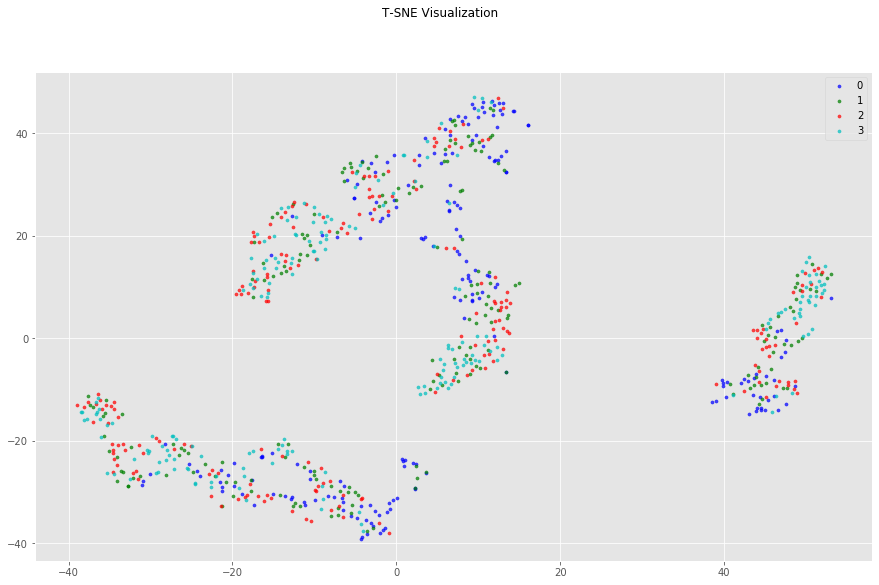

In [48]:
unique_labels = np.unique(labels)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots()
for i in range(len(unique_labels)):
    idxs = [j for j in range(len(labels)) if labels[j]==unique_labels[i]]
    ax.scatter(embeddings_test_2d[idxs,0], 
               embeddings_test_2d[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization',fontsize=12)
fig.set_size_inches(15,9)
plt.show()